TLDR : in this notebook we compare the photometry of the same objects by the same pipeline at different epochs. Of course, some objects could be inherently variable, but the majority of objects isn not.

### Table of contents : <a id='toc'></a>

[Step1  Find and process visits at different epochs](#step1)

[Step2  Use the visit info to compare different epochs](#step2)

[Step3 Summarize the spread ](#step3)

### Necessary Imports

In [6]:
import astropy.visualization as vis
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
import urllib.request
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.table import hstack
from astropy.table import vstack
from astropy import wcs
from itertools import product
from scipy.stats import binned_statistic as bs
import astropy.io.votable as vo
from astroML.stats._point_statistics import sigmaG

## Find and process visits at same location but different epochs <a id='step1'></a>

[Jump to top](#toc)

Given the fields that we already processed with LSST, could there be any other one that I could process that was taken at a similar location  ?


In [146]:
#visit_density_dic = {'20':[611529,609754,525814,525900],
#                     '15':[611970,525837,525838],
#                     '10':[611969,525846,525879],
#                     '5':[525904,525920]}  

# These are the high-density fields that already got processed,
# and don't have yet a pair ... 
visit_density_dic =  {'1': [644144, 644273],
                      '3': [567795, 644082],
                      '5': [567283, 644074, 527064],
                      '7': [526028, 641548], 
                      '10': [527453, 641497, 611969]}
densities = [1,1,3,3,5,5,5,7,7,10,10,10]
visit  = [644144, 644273,567795, 644082,567283, 644074, 527064,526028, 641548,
         527453, 641497, 611969]

visit_info = Table(data = [visit,densities], names=['visit', 'density'])

# Use the DECAPS-MAF cross-matched information table 
# from N0 
decaps_maf = Table.read('decapsIMDB_MAF_table', format='ascii')

# join on visits 
visits = join(decaps_maf, visit_info, keys='visit')

# sort by density
visits.sort('density')


# Nnow find out if there are any other visits than the 
# ones above at  roughly the same location , and 
# definitely the same filter and exptime 

decaps = decaps_maf.copy()
# Now cross-match the info table for fields that already got 
# processed with LSST against the entire rest of the imbd ...

# First, remove the 12 visits that we already processed so that 
# they wouldn't be matched to self ....
decaps_else = decaps[np.bitwise_not(np.in1d(decaps['visit'], visits['visit']))]
choose_filter=  decaps_else['filterid'] == 'g.0000'
choose_exp = decaps_else['exptime'] > 90
decaps_ = decaps_else[choose_filter*choose_exp]

# Next, match by coords
# express pixel coordinates as SkyCoord object, 
decaps_coords = SkyCoord(decaps_['ra'],decaps_['dec'], frame='icrs', 
                         unit='degree')

# express the decaps field coordinates as SkyCoord object ..
visits_coords = SkyCoord(ra = visits['ra'].data, dec = visits['dec'].data, 
                       unit='degree', frame='icrs')

idx, d2d, d3d = visits_coords.match_to_catalog_sky(decaps_coords)  

# stack the two catalogs 
stack_imdb = hstack([visits, decaps_[idx]])

# add column with distance to the nearest MAF pixel...
stack_imdb['d2d_deg'] = d2d.degree

# add a column with separation between visits in days 
stack_imdb['dmjd'] = stack_imdb['mjd_obs_1'] -stack_imdb['mjd_obs_2']

mask_d = stack_imdb['d2d_deg'] < 0.3
mask_exp1 = stack_imdb['exptime_1'] > 90
mask  = mask_d * mask_exp1

visit_info = stack_imdb[mask]

#visit_info[['density', 'visit_2','catfname_2', 'frac_greater_2',
#            'visit_1', 'dmjd', 'd2d_deg' ]]

# store commands to ingest all newly processed visitis 
# with a script ... 
x = len('c4d_160824_011313')
s = 'ingestImagesDecam.py repo/ noao_files/instcal/'
cmd = [s+line[:x]+'*' for line in visit_info['catfname_2']]
np.savetxt('cmd.txt',cmd, fmt='%s')

visit_info.write('decaps_rms_different_epoch_fields2.txt', format='ascii',
                 overwrite=True)

Ok, found 8 pairs, two per density, of fields that were observed at different but close epochs.

For the new fields I found 12 pairs, i.e. another visit that was at the same location as 12 already observed ones, but not necessarily very close in time . Does it matter that the obs are spaced by little in time ?  Here they are in the same location, but separated for some by over a year.... Perhaps not enough movement to notice any difference in a year ? 

Need to save the ones we want as a votable ...

Output of two queries : 
    
    SELECT *  FROM voi.siap WHERE dtpropid ILIKE '%2016A-0327%' AND proctype = 'InstCal' LIMIT 50000
    
that yields 11538 rows,  and 

    SELECT reference, release_date, start_date, dtacqnam,filter, exposure, dtnsanam, prodtype, filesize, dtpropid, md5sum  FROM voi.siap WHERE dtpropid ILIKE '%2016B-0279%' AND proctype = 'InstCal' LIMIT 50000
  
that yields 18524 rows, which combined provide me with all DECAPS files in NOAO database (wtmap, dqmask, imaging) . I hstack them to find out the names for all image products required for processing... 

In [ ]:
import astropy.io.votable as vo

# this is the outcome of querying for all from  '%2016A-0327%'
fname1 = 'rows_as_votable_1516932989_6863.vot.xml'  
table1 = vo.parse_single_table(fname1, invalid='mask') 
decaps_rows1 = table1.to_table()

# these are the results of querying for select rows from %2016B-0279% , 
fname2 = 'rows_as_votable_1517705044_1939.vot.xml'
table2 = vo.parse_single_table(fname2, invalid='mask') 
decaps_rows2 = table2.to_table()

print(len(decaps_rows1))
print(len(decaps_rows2))

In [70]:
# Stack with hstack : 
cols = decaps_rows2.colnames
decaps_rows = vstack([decaps_rows1[cols], decaps_rows2])


In [71]:
# Extract the visit number, match by the visit number ...
x1 = len('/data_local/images/DTS/2016A-0327/DECam_00')
x2 = len('.fits.fz')
visit = [line[x1:-x2] for line in decaps_rows['dtacqnam'].data.astype(str)]
decaps_rows['visit'] = visit

# Extract the full archive fname 
x = len('http://nsaserver.sdm.noao.edu:7003/?fileRef=')
archive = [line[x:] for line in decaps_rows['reference'].data.astype(str)]
decaps_rows['archive_fname'] = archive

# Extract the version number , removing all odd ones in the end...
x = len('v1.fits.fz')
v = [line[-x:-x+2] for line in decaps_rows['archive_fname']]
decaps_rows['version'] = v

In [73]:
# find the rows that are matching ... 
select = np.in1d(decaps_rows['visit'].data.data.astype(str), 
                 stack_imdb[mask]['visit_2'].data.astype(str))


# Display what we have found ... 
# there should be 3*8 = 24 rows ... 
print(decaps_rows[select]['visit','archive_fname', 'prodtype',])


visit            archive_fname            prodtype
------ ---------------------------------- --------
527552 c4d_160317_080227_oow_g_v1.fits.fz    wtmap
527552 c4d_160317_080227_ooi_g_v1.fits.fz    image
527552 c4d_160317_080227_ood_g_v1.fits.fz   dqmask
527555 c4d_160317_080735_oow_g_v1.fits.fz    wtmap
527555 c4d_160317_080735_ooi_g_v1.fits.fz    image
527555 c4d_160317_080735_ood_g_v1.fits.fz   dqmask
566793 c4d_160824_011313_oow_g_v1.fits.fz    wtmap
566793 c4d_160824_011313_ood_g_v1.fits.fz   dqmask
566793 c4d_160824_011313_ooi_g_v1.fits.fz    image
612757 c4d_170125_052727_ood_g_v1.fits.fz   dqmask
   ...                                ...      ...
644070 c4d_170428_032844_oow_g_v1.fits.fz    wtmap
644852 c4d_170429_080914_oow_g_v1.fits.fz    wtmap
644011 c4d_170428_015126_oow_g_v1.fits.fz    wtmap
644035 c4d_170428_022858_ooi_g_v1.fits.fz    image
644011 c4d_170428_015126_ooi_g_v1.fits.fz    image
645255 c4d_170430_054653_oow_g_v1.fits.fz    wtmap
644852 c4d_170429_080914_ood_g_

In [74]:
values, count = np.unique(decaps_rows[select]['visit'], return_counts=True)
for v,c in zip(values, count):
    print(v,c)

527552 3
527555 3
566793 3
612757 5
640995 3
641500 3
644011 3
644035 3
644070 3
644205 3
644852 3
645255 3


For some reason 612757  has more files ... check them out : 

In [75]:
m = decaps_rows[select]['visit'] == '612757'
decaps_rows[select][m]

reference,release_date,start_date,dtacqnam,filter,exposure,dtnsanam,prodtype,filesize,dtpropid,md5sum,visit,archive_fname,version
object,object,object,object,object,float64,object,object,int32,object,object,str6,str34,str2
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_ood_g_v1.fits.fz,2017-01-23,2017-01-24,/data_local/images/DTS/2016B-0279/DECam_00612757.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170125_052727_ood_g_v1.fits.fz,dqmask,10687680,2016B-0279,6561294c95ca81fec46b7b37caa0576f,612757,c4d_170125_052727_ood_g_v1.fits.fz,v1
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_ooi_g_v1.fits.fz,2017-01-23,2017-01-24,/data_local/images/DTS/2016B-0279/DECam_00612757.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170125_052727_ooi_g_v1.fits.fz,image,329984640,2016B-0279,695392378914db0eb371ef43bef8b9a5,612757,c4d_170125_052727_ooi_g_v1.fits.fz,v1
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_oow_g_v2.fits.fz,2017-01-23,2017-01-24,/data_local/images/DTS/2016B-0279/DECam_00612757.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170125_052727_oow_g_v2.fits.fz,wtmap,323881920,2016B-0279,23ba9b350dc42c4e82e492dd6994b12b,612757,c4d_170125_052727_oow_g_v2.fits.fz,v2
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_ood_g_v2.fits.fz,2017-01-23,2017-01-24,/data_local/images/DTS/2016B-0279/DECam_00612757.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170125_052727_ood_g_v2.fits.fz,dqmask,9650880,2016B-0279,f10be717e42bd1d429e893bf3bbe31bb,612757,c4d_170125_052727_ood_g_v2.fits.fz,v2
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_ooi_g_v2.fits.fz,2017-01-23,2017-01-24,/data_local/images/DTS/2016B-0279/DECam_00612757.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170125_052727_ooi_g_v2.fits.fz,image,335422080,2016B-0279,256cb3883e5767ab575c20674a946176,612757,c4d_170125_052727_ooi_g_v2.fits.fz,v2


Choose only v2 rather than v1 ... 

38

In [95]:
# Remove the unneccessary rows ...
m1 = decaps_rows['visit'] == '612757'
m2  = decaps_rows['version']  == 'v1'
index = np.arange(len(decaps_rows))
print(decaps_rows[m1*m2])
decaps_rows.remove_rows(index[m1*m2])

                                  reference                                    ...
------------------------------------------------------------------------------ ...
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_ood_g_v1.fits.fz ...
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_ooi_g_v1.fits.fz ...


In [100]:
# find the rows that are matching again... ... 
select = np.in1d(decaps_rows['visit'].data.data.astype(str), 
                 stack_imdb[mask]['visit_2'].data.astype(str))

print(np.sum(select))

36


In [101]:

# save that list of archive filenames 
# as a VOTable to download 
# with secure get 
N = np.sum(select)
fname = 'decaps_NOAO_download_votable_'+str(N)+'.vot.xml'
decaps_rows[select].write(fname,format='votable',
                          overwrite=True)
print('We saved %d names to download as %s'%(N,fname))

We saved 36 names to download as decaps_NOAO_download_votable_36.vot.xml


In [6]:
#decaps_rows[select]['archive_fname']

Now I scp that table to NCSA,  ssh , and execute secure_get script... 

    scp decaps_NOAO_download_votable_36.vot.xml scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/
    
    ssh scichris@lsst-dev01.ncsa.illinois.edu
    
    ./secure_get.sh decaps_NOAO_download_votable_36.vot.xml        

    mv c4d*ood*   noao_files/dqmask/
    mv c4d*ooi*   noao_files/instcal/
    mv c4d*oow*   noao_files/wtmap/

    source /ssd/lsstsw/stack/loadLSST.bash 
    
    setup obs_decam 
    
    ingestImagesDecam.py repo/ noao_files/instcal/c4d_1603*.fits.fz

Now process, starting from the lowest density ... 

    tmux 
    processCcd.py repo --rerun proc20perc  --id visit=529974^529989  -C config_processccd.py --clobber-config --clobber-versions  > proct20.log
    ctrl+d, b to detach 
    
    tmux , etc 
    processCcd.py repo --rerun proc15perc  --id visit=527247^527246  -C config_processccd.py --clobber-config --clobber-versions  > proct15.log

    processCcd.py repo --rerun proc10perc  --id visit=530032^530012  -C config_processccd.py --clobber-config --clobber-versions  > proct10.log
    
    processCcd.py repo --rerun proc5perc  --id visit=527296^527300  -C config_processccd.py --clobber-config --clobber-versions  > proct05.log
    
Keep checking progress :
    
    wc -l proct*
    
    

    

## Epochal cross-matching  <a id='step2'></a>

[Jump to top](#toc)

Save information about the two visits to $\LaTeX$ table 

In [25]:
from astropy.time import Time

# Read in the info about visit pairs ... 
visit_info1 = Table.read('decaps_rms_different_epoch_fields.txt', format='ascii')
visit_info2 = Table.read('decaps_rms_different_epoch_fields2.txt', format='ascii')

# remove the row with visit 644273 : it never got finished 
m = visit_info2['visit_1'] ==644273
visit_info2 = visit_info2[~m]

# add to the first set of pairs info about dmjd...
visit_info1['dmjd'] = visit_info1['mjd_obs_2']-visit_info1['mjd_obs_1']

# print which columns are present in each  - 
print(np.ravel(visit_info1.colnames))
print(np.ravel(visit_info2.colnames))

# let's stack them vertically, i.e. along rows ,
# with these columns remaining
print(np.array(visit_info2.colnames)[np.in1d(visit_info2.colnames,visit_info1.colnames)])

visit_info = vstack([visit_info1, visit_info2], join_type='inner')
visit_info.write('decaps_visits_different_epochs.txt', format='ascii',
               overwrite='True')

['visit_1' 'prodtype_1' 'exptime_1' 'mjd_obs_1' 'filterid_1' 'ra_1' 'dec_1'
 'sb_name_1' 'magzero_1' 'catfname_1' 'dtnsanam_1' 'visit_2' 'prodtype_2'
 'exptime_2' 'mjd_obs_2' 'filterid_2' 'ra_2' 'dec_2' 'sb_name_2'
 'magzero_2' 'catfname_2' 'dtnsanam_2' 'd2d_deg' 'density' 'dmjd']
['visit_1' 'prodtype_1' 'exptime_1' 'mjd_obs_1' 'filterid_1' 'ra_1' 'dec_1'
 'sb_name_1' 'magzero_1' 'catfname_1' 'dtnsanam_1' 'source_density_1'
 'ra_rad_1' 'dec_rad_1' 'N_px_greater_1' 'frac_greater_1' 'd2d_deg_1'
 'density' 'visit_2' 'prodtype_2' 'exptime_2' 'mjd_obs_2' 'filterid_2'
 'ra_2' 'dec_2' 'sb_name_2' 'magzero_2' 'catfname_2' 'dtnsanam_2'
 'source_density_2' 'ra_rad_2' 'dec_rad_2' 'N_px_greater_2'
 'frac_greater_2' 'd2d_deg_2' 'd2d_deg' 'dmjd']
['visit_1' 'prodtype_1' 'exptime_1' 'mjd_obs_1' 'filterid_1' 'ra_1' 'dec_1'
 'sb_name_1' 'magzero_1' 'catfname_1' 'dtnsanam_1' 'density' 'visit_2'
 'prodtype_2' 'exptime_2' 'mjd_obs_2' 'filterid_2' 'ra_2' 'dec_2'
 'sb_name_2' 'magzero_2' 'catfname_2' 'dtnsa

In [24]:
vstack?

In [8]:
## ASIDE ...       

# add a column with time separation information 
#mjd1 = Time(visit_info['mjd_obs_1'],format = 'mjd') 
visit_info['dmjd'] = visit_info['mjd_obs_2']-visit_info['mjd_obs_1']
visit_info['d2d_arcsec'] = visit_info['d2d_deg'] * 3600
visit_info_save = visit_info[['visit_1', 'ra_1','dec_1', 'magzero_1', 
            'visit_2','ra_2', 'dec_2', 'magzero_2',
           'd2d_arcsec', 'density', 'dmjd']]
visit_info_save.write('decaps_visits_epoch12.txt', format='latex',
                     overwrite='True')

## LSST-LSST , DECAPS-DECAPS: cross-match different epochs

For each pair at different epochs, load the clean catalogs from LSST or DECAPS. Cross-match. Save as cross-matched catalogs. 

In [9]:
from modules import crossmatch_catalogs

In [26]:
# Read in the info about visit pairs ... 
visit_info = Table.read('decaps_visits_different_epochs.txt', format='ascii')

# Match DECAPS to DECAPS, or LSST to LSST
pairs = [[visit_info['visit_1'][i],visit_info['visit_2'][i]] 
         for i in range(len(visit_info))]
for pair in pairs : 
    visit1,visit2 = pair[0], pair[1]
    for source in ['decaps','lsst' ] : 
        name = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        if name in os.listdir():
            print(name, ' was already xmatched  ...')
        else :
            cat12 = crossmatch_catalogs(sources=[source],visits=[visit1, visit2],
                                crossmatch_type = 'epochal', save_tables=True)
       

decaps-decaps525904-527300.txt  was already xmatched  ...
lsst-lsst525904-527300.txt  was already xmatched  ...
decaps-decaps525920-527296.txt  was already xmatched  ...
lsst-lsst525920-527296.txt  was already xmatched  ...
decaps-decaps525846-530012.txt  was already xmatched  ...
lsst-lsst525846-530012.txt  was already xmatched  ...
decaps-decaps525879-530032.txt  was already xmatched  ...
lsst-lsst525879-530032.txt  was already xmatched  ...
decaps-decaps525837-527246.txt  was already xmatched  ...
lsst-lsst525837-527246.txt  was already xmatched  ...
decaps-decaps525838-527247.txt  was already xmatched  ...
lsst-lsst525838-527247.txt  was already xmatched  ...
decaps-decaps525814-529974.txt  was already xmatched  ...
lsst-lsst525814-529974.txt  was already xmatched  ...
decaps-decaps525900-529989.txt  was already xmatched  ...
lsst-lsst525900-529989.txt  was already xmatched  ...
decaps-decaps644144-566793.txt  was already xmatched  ...
lsst-lsst644144-566793.txt  was already xmatch

In [34]:
visit_info[:3]

visit_1,prodtype_1,exptime_1,mjd_obs_1,filterid_1,ra_1,dec_1,sb_name_1,magzero_1,catfname_1,dtnsanam_1,visit_2,prodtype_2,exptime_2,mjd_obs_2,filterid_2,ra_2,dec_2,sb_name_2,magzero_2,catfname_2,dtnsanam_2,d2d_deg,density,dmjd
int64,str5,float64,float64,str6,float64,float64,str31,float64,str35,str26,int64,str5,float64,float64,str6,float64,float64,str31,float64,str35,str26,float64,int64,float64
525904,image,96.0,57461.1028366,g.0000,140.5531,-51.24729,c4d_160314_023031_ooi_g_v1.fits,29.47,c4d_160314_023031_ooi_g_v1.cat.fits,c4d_160314_023031_ori.fits,527300,image,96.0,57464.062762,g.0000,140.5534,-51.24555,c4d_160317_013249_ooi_g_v1.fits,29.459,c4d_160317_013249_ooi_g_v1.cat.fits,c4d_160317_013249_ori.fits,0.00175010448477,5,2.95992539
525920,image,96.0,57461.1197723,g.0000,143.2337,-51.44724,c4d_160314_025458_ooi_g_v1.fits,29.4465,c4d_160314_025458_ooi_g_v1.cat.fits,c4d_160314_025458_ori.fits,527296,image,96.0,57464.0585401,g.0000,143.2329,-51.446,c4d_160317_012643_ooi_g_v1.fits,29.259,c4d_160317_012643_ooi_g_v1.cat.fits,c4d_160317_012643_ori.fits,0.00133648672473,5,2.9387678
525846,image,96.0,57461.0384352,g.0000,133.5462,-44.27313,c4d_160314_005746_ooi_g_v1.fits,29.738,c4d_160314_005746_ooi_g_v1.cat.fits,c4d_160314_005746_ori.fits,530012,image,96.0,57474.0429131,g.0000,133.5508,-44.27435,c4d_160327_010413_ooi_g_v1.fits,29.783,c4d_160327_010413_ooi_g_v1.cat.fits,c4d_160327_010413_ori.fits,0.00351234787001,10,13.00447798


In [33]:
# Make a table that summarizes that: 

# DECAPS- DECAPS, or LSST-LSST 
# epoch1,  epoch2,  epoch1 N sources,  epoch2 N sources,  
# N matches within 0.5 arcses , N matches within 0.5 mag,  
# N matches within 0.5 arcsec and 0.5 mag ,
# dt 

visit_info = Table.read('decaps_visits_different_epochs.txt', format='ascii')

# Match DECAPS to DECAPS, or LSST to LSST
pairs = [[visit_info['visit_1'][i],visit_info['visit_2'][i]] 
         for i in range(len(visit_info))]

# Make storage arrays to store the info about crossmatching ....
dic = {'epoch1':np.zeros_like(visit_info['visit_1']),  
       'epoch2':np.zeros_like(visit_info['visit_1']),  
       'epoch1_Nsrc':np.zeros_like(visit_info['visit_1']),
       'epoch2_Nsrc':np.zeros_like(visit_info['visit_1']),
       'N_matched_sep' :np.zeros_like(visit_info['visit_1']),
       'N_matched_dmag':np.zeros_like(visit_info['visit_1']),
       'N_matched' :np.zeros_like(visit_info['visit_1']) 
      }
decaps =  Table(dic)
lsst = decaps.copy()

stats = {'decaps':decaps, 'lsst':lsst}

# go over each pair , consider both decaps-decaps, 
# and lsst-lsst matching ... 
for i,pair in enumerate(pairs) : 
    visit1,visit2 = pair[0], pair[1]
    for source in ['decaps','lsst' ] : 
        print(source,'-',source,': ',visit1,',',visit2)
        # the cross-matched table has the same length as visit1 
        name = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        cat = Table.read(name, format='ascii')
        
        # the clean table for visit2  gives the input number of sources 
        cat2 = Table.read(source+'_clean_'+str(visit2)+'.txt',format='ascii')
        
        mask_separation = cat['d2darcsec'].data < 0.5
        mask_mag = np.abs(cat[source+'_mag_1'] - cat[source+'_mag_2']) < 0.5 
        N_sep = np.sum(mask_separation)
        N_mag = np.sum(mask_mag)
        N_comb = np.sum(mask_mag * mask_separation)
        print(N_sep, N_mag, N_comb)
        stats[source]['epoch1'][i] = visit1
        stats[source]['epoch2'][i] = visit2
        stats[source]['epoch1_Nsrc'][i] = len(cat) 
        stats[source]['epoch2_Nsrc'][i] = len(cat2) 
        stats[source]['N_matched_sep'][i] = N_sep
        stats[source]['N_matched_dmag'][i] = N_mag
        stats[source]['N_matched'][i] = N_comb
print('Done calculating stats')

decaps - decaps :  525904 , 527300
381377 389606 377977
lsst - lsst :  525904 , 527300
289587 298445 288195
decaps - decaps :  525920 , 527296
308233 315512 305107
lsst - lsst :  525920 , 527296
233913 244288 232515
decaps - decaps :  525846 , 530012
105818 110103 105302
lsst - lsst :  525846 , 530012
85524 92474 85262
decaps - decaps :  525879 , 530032
604762 611662 598581
lsst - lsst :  525879 , 530032
351611 360597 350937
decaps - decaps :  525837 , 527246
284041 289133 280430
lsst - lsst :  525837 , 527246
217614 224611 216144
decaps - decaps :  525838 , 527247
222198 228701 219557
lsst - lsst :  525838 , 527247
182414 190278 181101
decaps - decaps :  525814 , 529974
180185 184938 179441
lsst - lsst :  525814 , 529974
137810 145607 137221
decaps - decaps :  525900 , 529989
116855 119479 116470
lsst - lsst :  525900 , 529989
98750 105534 98493
decaps - decaps :  644144 , 566793
1159628 56935 1097
lsst - lsst :  644144 , 566793
370104 15350 341
decaps - decaps :  567795 , 644205
5030

In [46]:
# add info about time separation

# summarize what percentage of epoch1 sources had match within 0.5 arcsec 
    # and 0.5 mag ... 
    
for source in ['lsst', 'decaps']:
    
    stats[source]['dmjd'] = 0
    for i,visit in  enumerate(stats[source]['epoch1']) :
        mask = visit_info['visit_1'] == visit
        stats[source]['dmjd'][i] = visit_info['dmjd'][mask]
    
    stats[source]['perc_matched']= stats[source]['N_matched'] \
        / stats[source]['epoch1_Nsrc']
        
    # Save the summary table 
    stats[source].write(source+'-'+source+'_xmatch_counts.txt', 
                        format='ascii', overwrite='True')

## Diagnostic plots of epoch-to-epoch comparison ... 

1) Spread of $\Delta m$ points

In [4]:
# Read in the info about visit pairs ... 
visit_info = Table.read('decaps_rms_different_epoch_fields.txt', format='ascii')

# Match DECAPS to DECAPS, or LSST to LSST
pairs = [[visit_info['visit_1'][i],visit_info['visit_2'][i]] 
         for i in range(len(visit_info))]

[[525904, 527300], [525920, 527296], [525846, 530012], [525879, 530032], [525837, 527246], [525838, 527247], [525814, 529974], [525900, 529989]]
Comparing  525904  to  527300  of  lsst


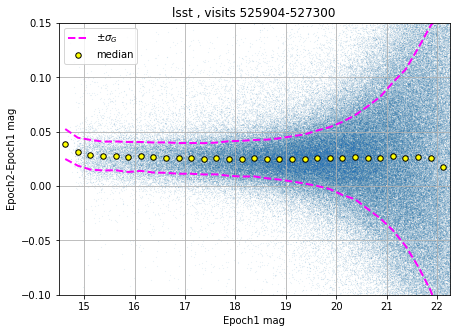

Comparing  525904  to  527300  of  decaps


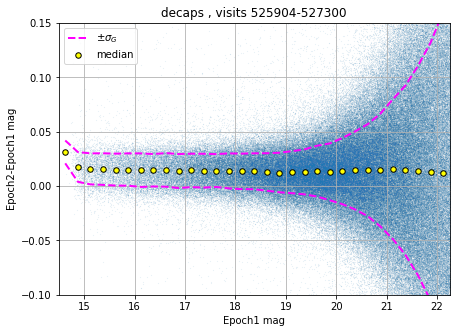

In [5]:
# Read-in cross-matched catalogs from various epochs 
#RMS : LSST_DECAPS comparison of the photometric scatter 

def plot_dmag(cat,ax,bins, source='lsst'):
    #bins = np.arange(14,23,0.5)
    mask_distance = cat['d2darcsec'].data < 0.5
    x = cat[mask_distance][source+'_mag_1']
    y = cat[mask_distance][source+'_mag_2']
    dm = y-x 
    
    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic

    # calculate the median per bin 
    median = bs(x,dm, bins=bins,statistic='median')
    med = median.statistic
    
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # plotting
    #fig,ax = plt.subplots(1,1)
    ax.scatter(x,y-x,s=0.001, label='')
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(-0.1, 0.15)
    ax.scatter(bin_centers , med ,s=30,c='yellow', edgecolors='k',
              label='median')
    ax.plot(bin_centers, med+sig, ls='--', lw=2, c='magenta', label=r'$\pm \sigma_{G}$')
    ax.plot(bin_centers, med-sig, ls='--', lw=2, c='magenta')
    ax.legend(loc='upper left')
    ax.set_xlabel('Epoch1 mag')
    ax.set_ylabel('Epoch2-Epoch1 mag')
    ax.grid()
    #ax.set_title(str(visit))
    #plt.savefig(str(visit)+'_half_arcsec_matches1.png', bbox_inches='tight')
    #plt.show()
%matplotlib inline    
bins = np.arange(14.5,22.5,0.25)
for pair in pairs[:1] : 
    print(pairs)
    visit1,visit2 = pair[0], pair[1]
    for source in ['lsst','decaps']:
        print('Comparing ', visit1, ' to ', visit2, ' of ', source )
        fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        cat = Table.read(fname, format='ascii')
        fig,ax= plt.subplots(1,1,figsize=(7,5))
        plot_dmag(cat,ax,bins, source=source)
        ax.set_title( source+' , visits '+str(visit1)+'-'+str(visit2))
        fname = source+'-'+source+str(visit1)+'-'+str(visit2) + '_dmag.png'
        plt.savefig( fname , bbox_inches='tight')
        plt.show()
# We positionally cross match DECAPS and LSST catalogs, and plot the 
# magnitude difference for objects within 0.5 arcsec from each other. 
# The median and sigmaG are calculated on full sample, i.e. 
# no clip on magnitude difference. 

# For completeness we also assumed that a match has to be within 
# 0.5 magnitude , but this does not affect median and sigmaG 
# which are not sensitive to rare outliers (objects 
# that are spatially close, but have a magnitude difference larger 
# than 0.5 magnitudes  )

## Multipanel plot of spread in magnitude difference between epochs <a id='step3'></a>

[Go to top](#toc)

First, create a column with mean LSST-DECAPS source count per visit pair : 

In [2]:
from astropy.table import Table

# generic info for all visits : DECAPS-LSST all info 
# one line per visit 
visit_table = Table.read('decaps_lsst_visit_info.txt', format='ascii')

# one row per pair 
chosen_visits = Table.read('decaps_visits_different_epochs.txt', format='ascii')

# using the vists_table, and the pairs table, 
# for each visit take the mean number DECAPS-LSST sources per sq.deg.,
# and for epoch1 call it N1,  for epoch2 call it N2 
chosen_visits['N1'] = 0
chosen_visits['N2'] = 0 
i = 0 
for visit in chosen_visits['visit_1'] : 
    row = visit_table['visit']  == visit 
    N = visit_table['mean_N_per_sq_deg'][row]
    chosen_visits['N1'][i] = N
    i += 1 
i = 0 
for visit in chosen_visits['visit_2'] : 
    row = visit_table['visit']  == visit 
    N = visit_table['mean_N_per_sq_deg'][row]
    chosen_visits['N2'][i] = N
    i += 1 

In [3]:
chosen_visits['meanN'] =(chosen_visits['N1']+ chosen_visits['N2'])/2.0
chosen_visits.sort('meanN')
chosen_visits.write('decaps_visits_epoch12_more.txt', format='ascii',
                   overwrite='True')

In [87]:
#chosen_visits

Now make a combined plot of rms for LSST-LSST,  and a separate plot of rms for DECAPS-DECAPS 

Comparing  525846  to  530012  of  lsst
Comparing  525900  to  529989  of  lsst
Comparing  525814  to  529974  of  lsst
Comparing  525838  to  527247  of  lsst
Comparing  611969  to  612757  of  lsst
Comparing  525837  to  527246  of  lsst
Comparing  525920  to  527296  of  lsst
Comparing  525904  to  527300  of  lsst
Comparing  641497  to  644035  of  lsst
Comparing  567283  to  645255  of  lsst
Comparing  644082  to  527555  of  lsst
Comparing  527453  to  640995  of  lsst
Comparing  525879  to  530032  of  lsst
Comparing  567795  to  644205  of  lsst
Comparing  527064  to  527552  of  lsst
Comparing  526028  to  641500  of  lsst
Comparing  641548  to  644011  of  lsst
Comparing  644144  to  566793  of  lsst
Comparing  644074  to  644070  of  lsst
Comparing  525846  to  530012  of  decaps
Comparing  525900  to  529989  of  decaps
Comparing  525814  to  529974  of  decaps
Comparing  525838  to  527247  of  decaps
Comparing  611969  to  612757  of  decaps
Comparing  525837  to  527246 

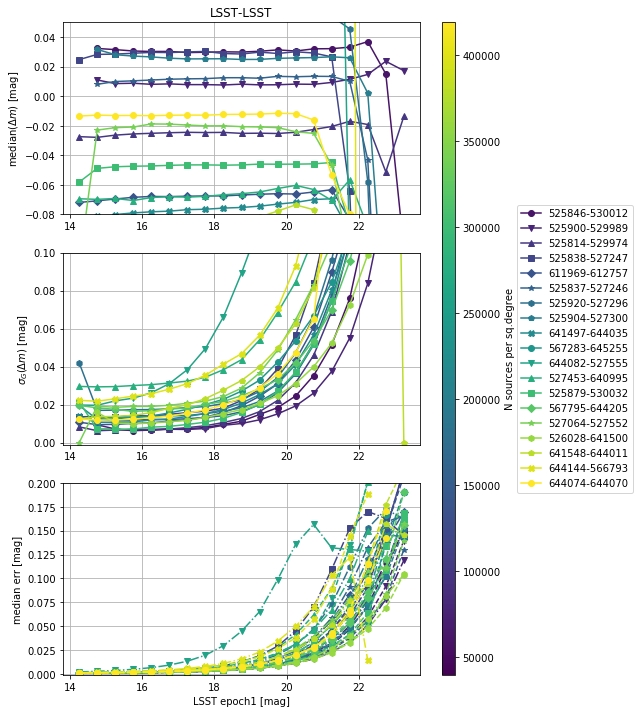

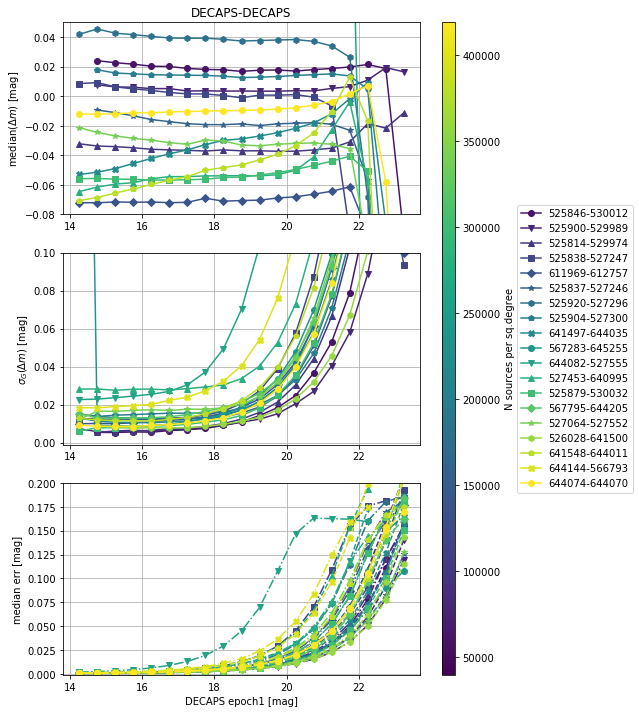

In [52]:
# calculate the spread : sigmaG
%matplotlib inline
import matplotlib
import matplotlib.lines as mlines
def plot_dmag_epoch_stats(cat,ax,bins, density,color,marker,source='lsst'):
    mask_distance = cat['d2darcsec'].data < 0.5
    x = cat[mask_distance][source+'_mag_1']
    y = cat[mask_distance][source+'_mag_2']
    dm = y-x 
    e1 = cat[mask_distance][source+'_magerr_1']
    e2 = cat[mask_distance][source+'_magerr_2']
    
    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic

    # calculate the median per bin 
    median = bs(x,dm, bins=bins,statistic='median')
    med = median.statistic
    
    # calculate median error 
    median_error1 = bs(x,e1, bins=bins, statistic='median')
    median_error2 = bs(x,e2, bins=bins, statistic='median')
    
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # plotting  median dmag 
    ax[0].plot(bin_centers , med, label=density, marker=marker, c=color)
    
    # plotting sigma dmag 
    ax[1].plot(bin_centers,sig,label=density,marker=marker, c=color)
    
    # plotting median error 
    ax[2].plot(bin_centers, median_error1.statistic, 
               label=density, marker=marker, c=color, ls='--')
    ax[2].plot(bin_centers, median_error2.statistic, 
               label=density, marker=marker, c=color, ls='-.')
    
pairs = [[chosen_visits['visit_1'][i],chosen_visits['visit_2'][i]] 
         for i in range(len(chosen_visits))]
    
cmap = matplotlib.cm.get_cmap('viridis')
markers = ['o','v', '^','s','D','*', 'h','p','X']
densities = chosen_visits['meanN']
N = len(densities)
colors = (np.arange(len(densities))+1)/N

bins = np.arange(14.5,22.5,0.25)

for source in ['lsst','decaps']:
    # Plot all densities for given processing center on one panel : 
    fig, ax=  plt.subplots(3,1, figsize=(8,12))
    bins = np.arange(14,24,0.5)
    ax_legend_handles = []
    for j, pair in enumerate(pairs) : 
        #print(pairs)
        visit1,visit2 = pair[0], pair[1]
        print('Comparing ', visit1, ' to ', visit2, ' of ', source )
        density = densities[j]
        color = cmap(colors[densities == density][0])
        marker = markers[j%len(markers)]
        
        # read the cross-matched catalog 
        fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        cat = Table.read(fname, format='ascii')
        
        # make a line for the legend, one line per visit 
        line = mlines.Line2D([], [], color=color, marker=marker,
                         label=str(visit1)+'-'+str(visit2))
        ax_legend_handles.append(line)
    
    
        plot_dmag_epoch_stats(cat,ax,bins, density,color,marker,source)

        
    if source is 'lsst' : 
        title = 'LSST'
    else: 
        title = 'DECAPS'

    ax[0].set_title(title+'-'+title)

    ax[0].set_ylabel('median'+r'$ (\Delta m)$'+' [mag]')
    ax[0].set_ylim(-0.08, 0.05)

    ax[1].set_ylabel(r'$\sigma_{G} (\Delta m)$ [mag]')
    ax[1].set_ylim(-0.001,0.1)

    #ax[2].set_ylabel('rms [mag]')
    #ax[2].set_ylim(-0.01,0.25)

    ax[2].set_ylabel('median err [mag]')
    ax[2].set_ylim(-0.001,0.2)
    
    ax[2].set_xlabel(title+' epoch1 [mag]')

    # put the legend outside the plot 
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    for i in range(len(ax)):
        ax[i].grid()

    #ax[1].legend(handles = ax_legend_handles,
    #             bbox_to_anchor=(0.31,0.5),
    #              fancybox=True, loc="center left")

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(densities), 
                                                      vmax=max(densities)))
    sm._A = []
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in ax.flat],
                                          aspect=50)
    plt.colorbar(sm, cax=cax,
                 label='N sources per sq.degree') 

    # add a legend with visits to the panels 
    plt.legend(bbox_to_anchor=(5.3,0.5),
         fancybox=True, loc="center left",
         handles = ax_legend_handles, ncol=1)
    fname = source+'-'+source+'_spread_plot_N_real_lims.png'
    plt.savefig(fname, bbox_inches='tight')
    print('Saved as ', fname)


Make a figure that enables direct comparison of DECAPS-LSST,  DECAPS-DECAPS, LSST-LSST  photometric spread : plot the $\sigma_{G}(\Delta m)$ as a function of magnitude for each of the fields that have a pair...   

We would  do  DECAPS-DECAPS,  LSST-LSST  on visit_1  vs visit_2,  
and plot DECAPS-LSST  on visit_1. So in total we could have 8 plots ( one for 
each visit1 in the chosen_visits above) 

### 1) Plot the constituent elements of comparing photometric accuracy 

Comparing  525846  to  530012  of  decaps
lsst - lsst
decaps - decaps
decaps-lsst
decaps-lsst


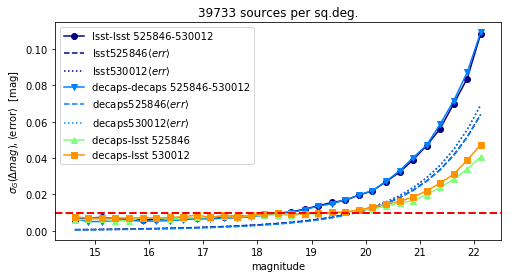

Comparing  525900  to  529989  of  decaps
lsst - lsst
decaps - decaps
decaps-lsst
decaps-lsst


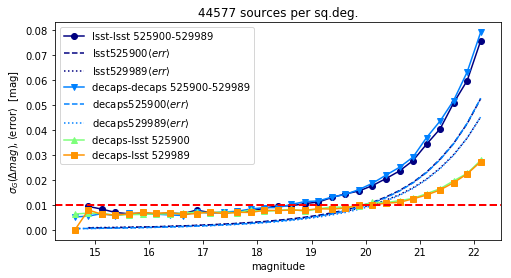

Done


In [72]:
import matplotlib.cm as cm
pairs = [[chosen_visits['visit_1'][i],chosen_visits['visit_2'][i]] 
         for i in range(len(chosen_visits))]
    
cmap = cm.get_cmap('jet')
markers = ['o','v', '^','s','D','*', 'h','p','X']
densities = chosen_visits['meanN']
colors = np.arange(3+1)/4

bins = np.arange(14.5,22.5,0.25)
bin_centers = (bins[:-1] + bins[1:])/2


for j, pair in enumerate(pairs[:2]) :
    #print(pairs)
    visit1,visit2 = pair[0], pair[1]
    print('Comparing ', visit1, ' to ', visit2, ' of ', source )
    density = densities[j]
        
    fig, ax=  plt.subplots(1,1, figsize=(8,4))   

    # ADD the sigmaG of LSST-LSST and DECAPS-DECAPS 
    for k,source in enumerate(['lsst','decaps']): 
        print(source,'-',source)
        # set marker and color - here they don't correspond to 
        # density or anything, just being different 
        marker = markers[k%len(markers)]
        color = cmap(colors[k]) 
        
        # read the cross-matched catalog 
        fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        cat = Table.read(fname, format='ascii')
        
        # select points within 0.5 arcsec ... 
        mask_distance = cat['d2darcsec'].data < 0.5
        x = cat[mask_distance][source+'_mag_1']
        y = cat[mask_distance][source+'_mag_2']
        dm = y-x 
        e1 = cat[mask_distance][source+'_magerr_1'] # this is e1L or e1D
        e2 = cat[mask_distance][source+'_magerr_2'] # this is e2L or e2D 

        # calculate the spread : sigmaG 
        spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
        sig = spread_sig.statistic
        
        # calculate the median error 
        median_error1 = bs(x,e1, bins=bins, statistic='median')
        median_error2 = bs(x,e2, bins=bins, statistic='median')
        
        # plot sigmaG with solid lines and markers
        ax.plot(bin_centers,sig, 
                label=source+'-'+source+' '+str(visit1)+'-'+str(visit2),
                marker=marker,c=color)
        
        # plot median error for both visits with dashed lines 
        ax.plot(bin_centers, median_error1.statistic, ls='--', c=color,
               label=source+str(visit1)+r'$\langle err \rangle$')
        
        ax.plot(bin_centers, median_error2.statistic, ls=':', c=color,
               label=source+str(visit2)+r'$\langle err \rangle$')

        
    # ADD DECAPS-LSST for visit1 , visit2 
    for visit in [visit1, visit2]:
        k += 1  # choose the next color  and marker 
        marker = markers[k%len(markers)] 
        color = cmap(colors[k])
        print('decaps-lsst')
        decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
        mask_distance = decaps_lsst['d2darcsec'].data < 0.5
        x = decaps_lsst[mask_distance]['decaps_mag']
        y = decaps_lsst[mask_distance]['lsst_mag']
        #e1 = decaps_lsst[mask_distance]['decaps_magerr']  # e1D 
        #e2 = decaps_lsst[mask_distance]['lsst_magerr']   # e1L 
        dm = y-x 
        
        # calculate the spread : sigmaG 
        spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
        sig = spread_sig.statistic
        
        # calculate median error 
        #median_error1 = bs(x,e1, bins=bins, statistic='median')
        #median_error2 = bs(x,e2, bins=bins, statistic='median')

        ax.plot(bin_centers,sig, 
                label='decaps-lsst '+str(visit), 
                marker=marker, c=color)
    #ax.plot(bin_centers, median_error1.statistic, c=color, ls='--', 
    #      label='decaps'+str(visit1)+r'$\langle err \rangle$')
    #ax.plot(bin_centers, median_error2.statistic, c=color, ls='-.',
    #       label='lsst'+str(visit1)+r'$\langle err \rangle$')
    ax.set_title(str(int(density)) + ' sources per sq.deg.')
    ax.set_ylabel(r'$\sigma_{G}(\Delta mag), \langle \mathrm{error} \rangle$  [mag]')
    ax.set_xlabel('magnitude')
    ax.axhline(0.01, ls='--', lw=2, c='red')
    ax.legend()
    
    plt.savefig('photometric_spread_1_'+str(visit1)+'-'+str(visit2)+'.png',
               bbox_inches='tight')
    plt.show()
    
print('Done') 

### 2) Plot the mean spread $\sigma_{DL}$, mean error  $e_{12}$: average quantities 

On the plot below we take the mean of errors added in quadrature between two visits. We only use LSST error, since as can be seen above, the LSST  or DECAPS errors for the same visit are very similar. ( LSST $e_{1L}$ or DECAPS $e_{1D}$ errors for one visit are dashed, and LSST $e_{2L}$ or DECAPS $e_{2D}$ errors for another visit are dotted ). Thus the mean is $e_{12} = \sqrt{e_{1L}^{2} + e_{2L}^{2}} / \sqrt{2}$

We also add in quadrature the spread between the two pipelines, represented  above by orange $\sigma_{DL,1}$ for visit1, and green $\sigma_{DL,2}$ for visit2 : 

$\sigma_{DL} = \sqrt{\sigma_{DL,1}^{2} + \sigma_{DL,2}^{2}} / \sqrt{2}$

In [41]:
import matplotlib.cm as cm
pairs = [[chosen_visits['visit_1'][i],chosen_visits['visit_2'][i]] 
         for i in range(len(chosen_visits))]
    
cmap = cm.get_cmap('jet')
markers = ['o','v', '^','s','D','*', 'h','p','X']
densities = chosen_visits['meanN']
colors = np.arange(3+1)/4

col = ['red', cmap(colors[1]),cmap(colors[2]),cmap(colors[3])]

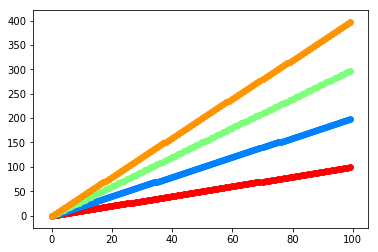

In [43]:
# Show what this selection looks like

%matplotlib inline
cmap = cm.get_cmap('jet',4)
x = np.arange(100)
for i in range(4):
    plt.scatter(x,x*(1+i),c=col[i])
    

Comparing  525846  to  530012
lsst - lsst
decaps - decaps
lsst - lsst
decaps-lsst


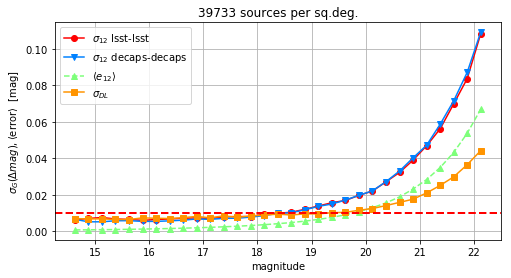

Comparing  525900  to  529989
lsst - lsst
decaps - decaps
lsst - lsst
decaps-lsst


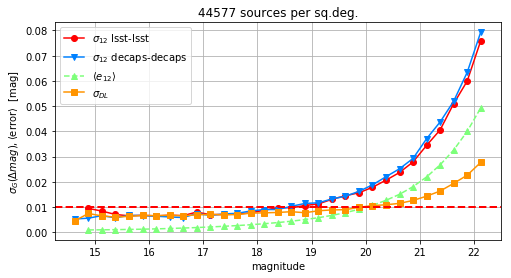

Done


In [44]:

bins = np.arange(14.5,22.5,0.25)
bin_centers = (bins[:-1] + bins[1:])/2

for j, pair in enumerate(pairs[:2]) :
    visit1,visit2 = pair[0], pair[1]
    print('Comparing ', visit1, ' to ', visit2 )
    density = densities[j]
        
    fig, ax=  plt.subplots(1,1, figsize=(8,4))   
    
    # read and store in a dictionary since I use it twice 
    catalogs = {}
    for source in ['lsst','decaps']:
        # read the cross-matched catalog 
        fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        cat = Table.read(fname, format='ascii')
        catalogs[source] = cat
        
    ########################################
    # ADD the sigmaG of LSST-LSST and DECAPS-DECAPS 
    # empirical measure of noise 
    ########################################
    for k,source in enumerate(['lsst','decaps']): 
        print(source,'-',source)
        # set marker and color - here they don't correspond to 
        # density or anything, just being different 
        marker = markers[k%len(markers)]
        color = col[k]  #cmap(colors[k]) 
        
        # cross-matched catalog 
        cat = catalogs[source]
        
        # select points within 0.5 arcsec ... 
        mask_distance = cat['d2darcsec'].data < 0.5
        x = cat[mask_distance][source+'_mag_1']
        y = cat[mask_distance][source+'_mag_2']
        dm = y-x 
        
        # calculate the spread : sigmaG 
        spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
        sig = spread_sig.statistic
        
        # plot sigmaG with solid lines and markers
        ax.plot(bin_centers,sig, 
                label=r'$\sigma_{12}$'+' '+source+'-'+source,
                marker=marker,c=color)
        
    #########################
    # ADD LSST-LSST mean error
    #########################
    k += 1 
    source = 'lsst'
    print(source,'-',source)
    # set marker and color - here they don't correspond to 
    # density or anything, just being different 
    marker = markers[k%len(markers)]
    color = col[k] # cmap(colors[k]) 
    
    # cross-matched catalog 
    cat = catalogs[source]

    # select points within 0.5 arcsec ... 
    mask_distance = cat['d2darcsec'].data < 0.5
    x = cat[mask_distance][source+'_mag_1']
    e1 = cat[mask_distance][source+'_magerr_1'] # this is e1L or e1D
    e2 = cat[mask_distance][source+'_magerr_2'] # this is e2L or e2D 

    # add errors in quadrature 
    e12 = np.sqrt(e1**2.0 + e2**2.0) / np.sqrt(2.0)
        
    # calculate the median error 
    
    median_error12 = bs(x,e12, bins=bins, statistic='median')

    # plot median error for both visits with dashed lines 
    ax.plot(bin_centers, median_error12.statistic, ls='--', c=color,marker=marker,
           label=r'$\langle e_{12} \rangle$')
        
    #########################   
    # ADD DECAPS-LSST sigma_DL  for visit1 , visit2 
    #########################
    k += 1  # choose the next color  and marker 
    marker = markers[k%len(markers)] 
    color = col[k] # cmap(colors[k])
    print('decaps-lsst')
    
    #### visit1
    decaps_lsst = Table.read('decaps-lsst-'+str(visit1)+'.txt', format='ascii')
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    dm = y-x 

    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig1 = spread_sig.statistic

    #### visit2
    decaps_lsst = Table.read('decaps-lsst-'+str(visit2)+'.txt', format='ascii')
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    dm = y-x 

    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig2 = spread_sig.statistic
     
    # add in quadrature 
    sig = np.sqrt(sig1**2.0 + sig2**2.0) / np.sqrt(2.0)

    ax.plot(bin_centers,sig, 
            label=r'$\sigma_{DL}$',   marker=marker, c=color)
    ax.set_title(str(int(density)) + ' sources per sq.deg.')
    ax.set_ylabel(r'$\sigma_{G}(\Delta mag), \langle \mathrm{error} \rangle$  [mag]')
    ax.set_xlabel('magnitude')
    ax.axhline(0.01, ls='--', lw=2, c='red')
    ax.legend()
    ax.grid()
    plt.savefig('photometric_spread_2_'+str(visit1)+'-'+str(visit2)+'.png',
               bbox_inches='tight')
    plt.show()
    
print('Done') 

Looks good . Since the measured spread in photometry $\sigma_{DD}$, $\sigma_{LL}$ ( top blue lines) consists of noise  $e_{12}$ and systematic offset $\sigma_{S}$ :

$\sigma_{DD}^{2} = e_{12}^{2} + \sigma_{S}^{2}$  (similarly for  $\sigma_{LL}$)
    
Thus we can calculate the systematic offset : 

$\sigma_{S} = \sqrt{\sigma_{DD}^2  -e_{12}^{2} }$  ( or $\sigma_{LL}^{2}$ ) 

    

Comparing  525846  to  530012  of  decaps
lsst - lsst
lsst - lsst
decaps - decaps
decaps-lsst


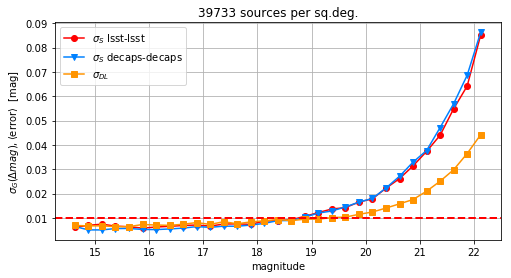

Comparing  525900  to  529989  of  decaps
lsst - lsst
lsst - lsst
decaps - decaps
decaps-lsst


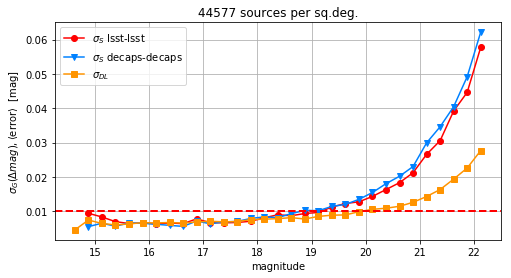

Comparing  525814  to  529974  of  decaps
lsst - lsst
lsst - lsst
decaps - decaps
decaps-lsst


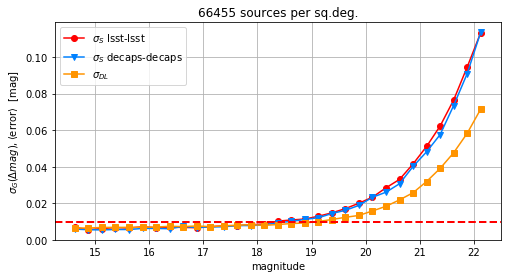

Comparing  525838  to  527247  of  decaps
lsst - lsst
lsst - lsst


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt


decaps - decaps
decaps-lsst


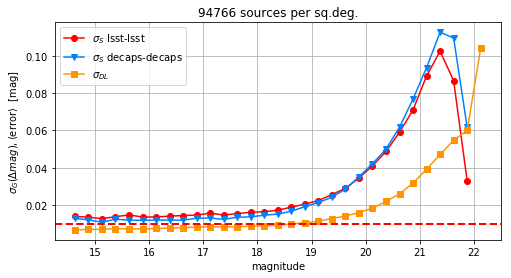

Comparing  611969  to  612757  of  decaps
lsst - lsst
lsst - lsst
decaps - decaps
decaps-lsst


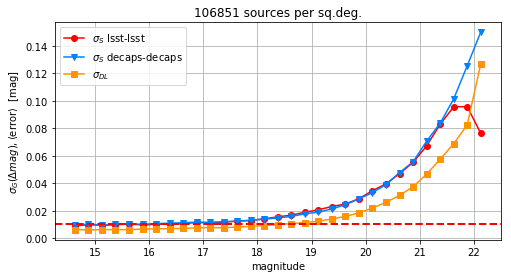

Comparing  525837  to  527246  of  decaps
lsst - lsst
lsst - lsst
decaps - decaps
decaps-lsst


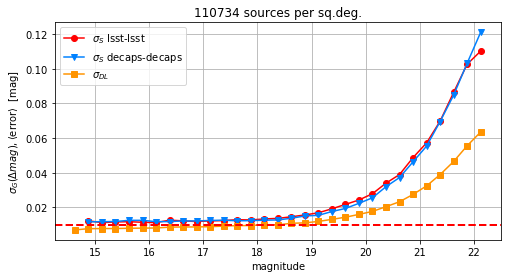

Comparing  525920  to  527296  of  decaps
lsst - lsst
lsst - lsst
decaps - decaps
decaps-lsst


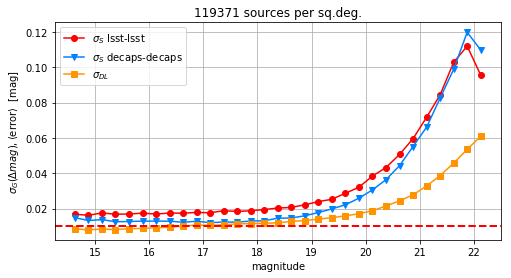

Comparing  525904  to  527300  of  decaps
lsst - lsst
lsst - lsst
decaps - decaps
decaps-lsst


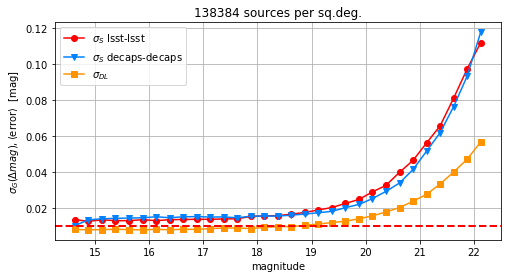

Done


In [47]:
import matplotlib.cm as cm
pairs = [[chosen_visits['visit_1'][i],chosen_visits['visit_2'][i]] 
         for i in range(len(chosen_visits))]
    
cmap = cm.get_cmap('jet')
markers = ['o','v', '^','s','D','*', 'h','p','X']
densities = chosen_visits['meanN']
colors = np.arange(3+1)/4

bins = np.arange(14.5,22.5,0.25)
bin_centers = (bins[:-1] + bins[1:])/2

for j, pair in enumerate(pairs[:8]) :
    visit1,visit2 = pair[0], pair[1]
    print('Comparing ', visit1, ' to ', visit2, ' of ', source )
    density = densities[j]
        
    fig, ax=  plt.subplots(1,1, figsize=(8,4))   
    
    
    # read and store in a dictionary since I use it twice 
    catalogs = {}
    for source in ['lsst','decaps']:
        # read the cross-matched catalog 
        fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        cat = Table.read(fname, format='ascii')
        catalogs[source] = cat
        
    ########################################
    # calculate e12 LSST-LSST
    ########################################
    source = 'lsst'
    print(source,'-',source)
    
    # cross-matched catalog 
    cat = catalogs[source]

    # select points within 0.5 arcsec ... 
    mask_distance = cat['d2darcsec'].data < 0.5
    x = cat[mask_distance][source+'_mag_1']
    e1 = cat[mask_distance][source+'_magerr_1'] # this is e1L or e1D
    e2 = cat[mask_distance][source+'_magerr_2'] # this is e2L or e2D 

    # add errors in quadrature 
    e12 = np.sqrt(e1**2.0 + e2**2.0) / np.sqrt(2.0)
        
    # calculate the median error 
    median_error12 = bs(x,e12, bins=bins, statistic='median')
    median_e12 = median_error12.statistic
    
    ########################################
    # ADD the sigmaG of LSST-LSST and DECAPS-DECAPS 
    # empirical measure of noise 
    ########################################
    for k,source in enumerate(['lsst','decaps']): 
        print(source,'-',source)
        # set marker and color - here they don't correspond to 
        # density or anything, just being different 
        marker = markers[k%len(markers)]
        color = col[k] #  cmap(colors[k]) 
        
        # cross-matched catalog 
        cat = catalogs[source]
        
        # select points within 0.5 arcsec ... 
        mask_distance = cat['d2darcsec'].data < 0.5
        x = cat[mask_distance][source+'_mag_1']
        y = cat[mask_distance][source+'_mag_2']
        dm = y-x 
        
        # calculate the spread : sigmaG 
        spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
        sig = spread_sig.statistic
        
        # subtract one from the other 
        sigS = np.sqrt(sig**2.0 - median_e12**2.0)
        
        # plot sigmaG with solid lines and markers
        ax.plot(bin_centers,sigS, 
                label=r'$\sigma_{S}$'+' '+source+'-'+source,
                marker=marker,c=color)
    
    #########################   
    # ADD DECAPS-LSST sigma_DL  for visit1 , visit2 
    #########################
    k += 2  # choose the next color  and marker 
    marker = markers[k%len(markers)] 
    color = col[k] # cmap(colors[k])
    print('decaps-lsst')
    
    #### visit1
    decaps_lsst = Table.read('decaps-lsst-'+str(visit1)+'.txt', format='ascii')
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    dm = y-x 

    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig1 = spread_sig.statistic

    #### visit2
    decaps_lsst = Table.read('decaps-lsst-'+str(visit2)+'.txt', format='ascii')
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    dm = y-x 

    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig2 = spread_sig.statistic
     
    # add in quadrature 
    sig = np.sqrt(sig1**2.0 + sig2**2.0) / np.sqrt(2.0)

    ax.plot(bin_centers,sig, 
            label=r'$\sigma_{DL}$',   marker=marker, c=color)
    
   # setup standard plot 
    ax.set_title(str(int(density)) + ' sources per sq.deg.')
    ax.set_ylabel(r'$\sigma_{G}(\Delta mag), \langle \mathrm{error} \rangle$  [mag]')
    ax.set_xlabel('magnitude')
    ax.axhline(0.01, ls='--', lw=2, c='red')
    ax.legend()
    ax.grid()
    plt.savefig('photometric_spread_3_'+str(visit1)+'-'+str(visit2)+'.png',
               bbox_inches='tight')
    plt.show()
    
print('Done') 

In [132]:
#Plot sigmaS at 21st mag as a function of stellar density ... 

pairs = [[chosen_visits['visit_1'][i],chosen_visits['visit_2'][i]] 
         for i in range(len(chosen_visits))]
    
bins = np.arange(14.5,22.5,0.25)
bin_centers = (bins[:-1] + bins[1:])/2

# go over visit pairs 
dic = {}
for j, pair in enumerate(pairs) :
    visit1,visit2 = pair[0], pair[1]
    print('Comparing ', visit1, ' to ', visit2 )
     
    
    # read and store in a dictionary since I use it twice 
    catalogs = {}
    for source in ['lsst','decaps']:
        # read the cross-matched catalog 
        fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        cat = Table.read(fname, format='ascii')
        catalogs[source] = cat
        
    ########################################
    # calculate e12 LSST-LSST
    ########################################
    source = 'lsst'
    
    # cross-matched catalog 
    cat = catalogs[source]

    # select points within 0.5 arcsec ... 
    mask_distance = cat['d2darcsec'].data < 0.5
    x = cat[mask_distance][source+'_mag_1']
    e1 = cat[mask_distance][source+'_magerr_1'] # this is e1L or e1D
    e2 = cat[mask_distance][source+'_magerr_2'] # this is e2L or e2D 

    # add errors in quadrature 
    e12 = np.sqrt(e1**2.0 + e2**2.0) / np.sqrt(2.0)
        
    # calculate the median error 
    median_error12 = bs(x,e12, bins=bins, statistic='median')
    median_e12 = median_error12.statistic
    
    ########################################
    # ADD the sigmaG of LSST-LSST and DECAPS-DECAPS 
    # empirical measure of noise 
    ########################################
    dic[visit1]= {}
    for k,source in enumerate(['lsst','decaps']):
        # cross-matched catalog 
        cat = catalogs[source]
        
        # select points within 0.5 arcsec ... 
        mask_distance = cat['d2darcsec'].data < 0.5
        x = cat[mask_distance][source+'_mag_1']
        y = cat[mask_distance][source+'_mag_2']
        dm = y-x 
        
        # calculate the spread : sigmaG 
        spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
        sig = spread_sig.statistic
        
        # subtract one from the other in quadrature
        sigS = np.sqrt(sig**2.0 - median_e12**2.0)
        
        dic[visit1][source] = sigS
        
print('Done') 

Comparing  525846  to  530012
Comparing  525900  to  529989
Comparing  525814  to  529974
Comparing  525838  to  527247


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in sqrt
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in sqrt


Comparing  611969  to  612757
Comparing  525837  to  527246
Comparing  525920  to  527296
Comparing  525904  to  527300
Comparing  641497  to  644035
Comparing  567283  to  645255
Comparing  644082  to  527555


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in sqrt


Comparing  527453  to  640995
Comparing  525879  to  530032
Comparing  567795  to  644205
Comparing  527064  to  527552
Comparing  526028  to  641500
Comparing  641548  to  644011
Comparing  644144  to  566793
Comparing  644074  to  644070
Done


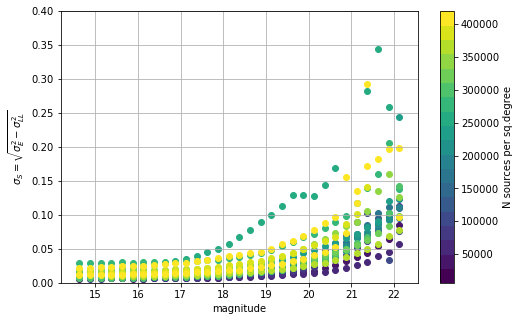

In [136]:

markers = ['o','v', '^','s','D','*', 'h','p','X']
densities = chosen_visits['meanN']
N = len(densities)
cmap = matplotlib.cm.get_cmap('viridis',N)
colors = (np.arange(len(densities))+1)/N

bins = np.arange(14.5,22.5,0.25)
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax_legend_handles = []        
for j, pair in enumerate(pairs) :
    visit1,visit2 = pair[0], pair[1]
    density = densities[j]
    color = cmap(colors[densities == density][0])
    source = 'lsst'
    ax.scatter(bin_centers, dic[visit1][source], color = color)
    
# add a big colorbar to the four panels   
densities = visit_table['mean_N_per_sq_deg']
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(densities), 
                           vmax=max(densities)))
sm._A = []
cax,kw = matplotlib.colorbar.make_axes([ax],
                                      aspect=20)
plt.colorbar(sm, cax=cax,
             label='N sources per sq.degree') 
ax.set_xlabel('magnitude')
ax.set_ylabel(r'$\sigma_{S} = \sqrt{\sigma_{E}^{2} - \sigma_{LL}^{2}}$')
ax.grid()
ax.set_ylim(0,0.4)
plt.savefig('photometric_offset.png', bbox_inches='tight')

In [139]:
from astropy.table import Column
# add columns 
chosen_visits['sigmaS_decaps'] = Column(data=[0], dtype=float)
chosen_visits['sigmaS_lsst'] = Column(data=[0], dtype=float)
# go over pairs ....
for j, pair in enumerate(pairs) :
    visit1,visit2 = pair[0], pair[1]
    for k,source in enumerate(['lsst','decaps']):
        sigS = dic[visit1][source] 
        sigS_21 = np.interp(21,bin_centers, sigS)
        chosen_visits['sigmaS_'+source][j] = sigS_21
    

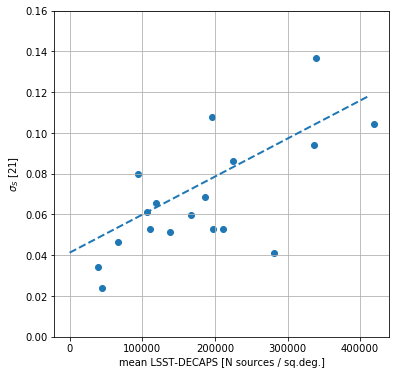

In [155]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

ax.scatter(chosen_visits['meanN'], chosen_visits['sigmaS_lsst'])
ax.set_ylim(0,0.16)

# then fit straight line to m50 vs density 
n, s = chosen_visits['meanN'], chosen_visits['sigmaS_lsst']
n = n[s<0.16]
s = s[s<0.16]
p = np.polyfit(n,s,1)
x = np.arange(40000, 450000)
ax.plot(p[0]*x + p[1], ls='--', lw=2)
ax.set_ylabel(r'$\sigma_{S} \,\,[21]$')
ax.set_xlabel('mean LSST-DECAPS [N sources / sq.deg.]')
ax.grid()
plt.savefig('photometric_offset_summary.png', bbox_inches='tight')

### DECAPS-DECAPS: repeatability completeness 

Consider pairs of DECAPS visits: calculate completeness 
 of visit1 to visit2, plot as a function of magnitude ... 

In [57]:
def calculate_completeness(table, bins ,source='decaps',
                      sep=0.5, dmag=0.5, ):
    '''
    We assume that source1 is matched to source2: 
    we ask how many objects from source1  have a match in source2. 
    This is expressed in terms of completeness. Source1 is 
    thus considered the 'truth'. The completeness is plotted 
    as a function of magnitude of source1. In the middle and 
    bottom panel we see counts as a function of magnitude for 
    source1 and source2. 
    '''
    # calculate the 'match' 
    table['match'] = 0
    mask_separation = table['d2darcsec'] < sep
    mask_dmag = np.abs(table[source+'_mag_1']-table[source+'_mag_2'])< dmag
    mask = mask_separation * mask_dmag
    print(np.sum(mask_separation))
    print(np.sum(mask_dmag))
    print(np.sum(mask))
    
    table['match'][mask] = 1 
    
    # calculate the plotted stats
    stat_decaps = bs(table[source+'_mag_1'], table[source+'_mag_2'] , 
                  bins = bins , statistic='count')
    cat1_count = stat_decaps.statistic

    stat_matched = bs(table[source+'_mag_1'],table['match'] , 
                        bins =bins , statistic=np.sum)
    cat2_matched_count = stat_matched.statistic
    completeness = 100 * (cat2_matched_count / cat1_count)

    dic = {'completeness':completeness}
    return dic

def calculate_count(x,bins, normed=True):
    ''' Compute the count per bin using scipy
    binned statistic. More versatile than histogram. 
    
    Parameters :
    ----------------
    normed : if True,  then normalizing by the total
        number of counts within the histogram bounds 
        ( not including anything beyond the scale of 
        the plot)
    '''
    stat_count = bs(x,x,bins=bins, statistic='count')
    count = stat_count.statistic 
    if normed : 
        count /= np.sum(count)
    return count

visit_1,prodtype_1,exptime_1,mjd_obs_1,filterid_1,ra_1,dec_1,sb_name_1,magzero_1,catfname_1,dtnsanam_1,visit_2,prodtype_2,exptime_2,mjd_obs_2,filterid_2,ra_2,dec_2,sb_name_2,magzero_2,catfname_2,dtnsanam_2,d2d_deg,density,dmjd,N1,N2,meanN
int64,str5,float64,float64,str6,float64,float64,str31,float64,str35,str26,int64,str5,float64,float64,str6,float64,float64,str31,float64,str35,str26,float64,int64,float64,int64,int64,float64
525846,image,96.0,57461.0384352,g.0000,133.5462,-44.27313,c4d_160314_005746_ooi_g_v1.fits,29.738,c4d_160314_005746_ooi_g_v1.cat.fits,c4d_160314_005746_ori.fits,530012,image,96.0,57474.0429131,g.0000,133.5508,-44.27435,c4d_160327_010413_ooi_g_v1.fits,29.783,c4d_160327_010413_ooi_g_v1.cat.fits,c4d_160327_010413_ori.fits,0.00351234787001,10,13.00447798,40602,38865,39733.5
525900,image,96.0,57461.0985956,g.0000,140.6165,-48.15003,c4d_160314_022428_ooi_g_v1.fits,29.772,c4d_160314_022428_ooi_g_v1.cat.fits,c4d_160314_022428_ori.fits,529989,image,96.0,57474.0155481,g.0000,140.6162,-48.15212,c4d_160327_002448_ooi_g_v1.fits,29.809,c4d_160327_002448_ooi_g_v1.cat.fits,c4d_160327_002448_ori.fits,0.00209956192516,20,12.91695244,42753,46402,44577.5
525814,image,96.0,57461.0044199,g.0000,126.4261,-43.06979,c4d_160314_000848_ooi_g_v1.fits,29.4545,c4d_160314_000848_ooi_g_v1.cat.fits,c4d_160314_000848_ori.fits,529974,image,96.0,57473.9968079,g.0000,126.4192,-43.07151,c4d_160326_235749_ooi_g_v1.fits,29.466,c4d_160326_235749_ooi_g_v1.cat.fits,c4d_160326_235749_ori.fits,0.00532591627293,20,12.99238801,64425,68486,66455.5
525838,image,96.0,57461.0299226,g.0000,132.5935,-50.30486,c4d_160314_004531_ooi_g_v1.fits,29.344,c4d_160314_004531_ooi_g_v1.cat.fits,c4d_160314_004531_ori.fits,527247,image,96.0,57464.0069262,g.0000,132.5894,-50.30705,c4d_160317_001229_ooi_g_v1.fits,28.991,c4d_160317_001229_ooi_g_v1.cat.fits,c4d_160317_001229_ori.fits,0.00341368885562,15,2.97700361,112242,77291,94766.5
611969,image,96.0,57775.2294122,g.0000,115.5322,-24.08125,c4d_170122_053255_ori.fits,28.871,c4d_170122_053255_ooi_g_v1.cat.fits,c4d_170122_053255_ooi_g_v1,612757,image,96.0,57778.2257133,g.0000,115.7918,-24.11406,c4d_170125_052727_ori.fits,28.761,c4d_170125_052727_ooi_g_v2.cat.fits,c4d_170125_052727_ooi_g_v2,0.239236588305,10,-2.99630101,113823,99879,106851.0
525837,image,96.0,57461.0284634,g.0000,131.5622,-48.59523,c4d_160314_004325_ooi_g_v1.fits,30.011,c4d_160314_004325_ooi_g_v1.cat.fits,c4d_160314_004325_ori.fits,527246,image,96.0,57464.0054807,g.0000,131.5601,-48.59695,c4d_160317_001026_ooi_g_v1.fits,29.699,c4d_160317_001026_ooi_g_v1.cat.fits,c4d_160317_001026_ori.fits,0.00221073263818,15,2.97701731,126490,94978,110734.0
525920,image,96.0,57461.1197723,g.0000,143.2337,-51.44724,c4d_160314_025458_ooi_g_v1.fits,29.4465,c4d_160314_025458_ooi_g_v1.cat.fits,c4d_160314_025458_ori.fits,527296,image,96.0,57464.0585401,g.0000,143.2329,-51.446,c4d_160317_012643_ooi_g_v1.fits,29.259,c4d_160317_012643_ooi_g_v1.cat.fits,c4d_160317_012643_ori.fits,0.00133648672473,5,2.9387678,134025,104718,119371.5
525904,image,96.0,57461.1028366,g.0000,140.5531,-51.24729,c4d_160314_023031_ooi_g_v1.fits,29.47,c4d_160314_023031_ooi_g_v1.cat.fits,c4d_160314_023031_ori.fits,527300,image,96.0,57464.062762,g.0000,140.5534,-51.24555,c4d_160317_013249_ooi_g_v1.fits,29.459,c4d_160317_013249_ooi_g_v1.cat.fits,c4d_160317_013249_ori.fits,0.00175010448477,5,2.95992539,148160,128609,138384.5
641497,image,96.0,57864.0769644,g.0000,166.4679,-53.71243,c4d_170421_015315_ori.fits,29.137,c4d_170421_015315_ooi_g_v1.cat.fits,c4d_170421_015315_ooi_g_v1,644035,image,96.0,57871.1017779,g.0000,166.732,-53.79675,c4d_170428_022858_ori.fits,29.033,c4d_170428_022858_ooi_g_v1.cat.fits,c4d_170428_022858_ooi_g_v1,0.17745970147,10,-7.02481346,175246,159289,167267.5


In [67]:
import matplotlib.cm as cm
pairs = [[chosen_visits['visit_1'][i],chosen_visits['visit_2'][i]] 
         for i in range(len(chosen_visits))]
    
cmap = cm.get_cmap('jet')
markers = ['o','v', '^','s','D','*', 'h','p','X']
densities = chosen_visits['meanN']
colors = np.arange(3+1)/4

bins = np.arange(14.5,22.5,0.25)
bin_centers = (bins[:-1] + bins[1:])/2

stats = {'bins':[], 'i':[], 'visit1':[], 'visit2':[],
         'density':[],
         'decaps1-decaps2_completeness':[], 
        'decaps1_count':[],
        'decaps2_count':[] }
 
    
for j, pair in enumerate(pairs) :
    source = 'decaps'
    visit1,visit2 = pair[0], pair[1]
    print('Comparing ', visit1, ' to ', visit2, ' of ', source )
        
    stats['bins'].append(bins)
    stats['i'].append(j)
    stats['visit1'].append(visit1)
    stats['visit2'].append(visit2)
    density = int(densities[j])
    stats['density'].append(density)

    # read in the epoch-epoch cross-matched catalog
    fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
    table = Table.read(fname, format='ascii')
    
    # calculate completeness decaps visit1 - decaps visit2  
    # visit1 is the 'truth'
    dic = calculate_completeness(table, bins,source)     
    stats['decaps1-decaps2_completeness'].append(dic['completeness'])
    
    # calculate counts 
    count1 = calculate_count(table[source+'_mag_1'],bins, normed=True)
    count2 = calculate_count(table[source+'_mag_2'],bins, normed=True)
    stats['decaps1_count'].append(count1)
    stats['decaps2_count'].append(count2)

Comparing  525846  to  530012  of  decaps
105818
110103
105302
Comparing  525900  to  529989  of  decaps
116855
119479
116470
Comparing  525814  to  529974  of  decaps
180185
184938
179441
Comparing  525838  to  527247  of  decaps
222198
228701
219557
Comparing  611969  to  612757  of  decaps
215903
234813
213882
Comparing  525837  to  527246  of  decaps
284041
289133
280430
Comparing  525920  to  527296  of  decaps
308233
315512
305107
Comparing  525904  to  527300  of  decaps
381377
389606
377977
Comparing  641497  to  644035  of  decaps
382943
411636
376930
Comparing  567283  to  645255  of  decaps
503655
4031
586
Comparing  644082  to  527555  of  decaps
393954
164912
928
Comparing  527453  to  640995  of  decaps
612090
623374
606980
Comparing  525879  to  530032  of  decaps
604762
611662
598581
Comparing  567795  to  644205  of  decaps
503056
31492
3724
Comparing  527064  to  527552  of  decaps
655395
680467
644394
Comparing  526028  to  641500  of  decaps
864666
64775
57744


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Comparing  641548  to  644011  of  decaps
833874
903433
814391
Comparing  644144  to  566793  of  decaps
1159628
56935
1097
Comparing  644074  to  644070  of  decaps
1210193
1281456
1202258


Plotting  525846  to  530012  of  decaps
Plotting  525900  to  529989  of  decaps
Plotting  525814  to  529974  of  decaps
Plotting  525838  to  527247  of  decaps
Plotting  525837  to  527246  of  decaps
Plotting  525920  to  527296  of  decaps
Plotting  525904  to  527300  of  decaps
Plotting  527453  to  640995  of  decaps
Plotting  525879  to  530032  of  decaps
Plotting  527064  to  527552  of  decaps


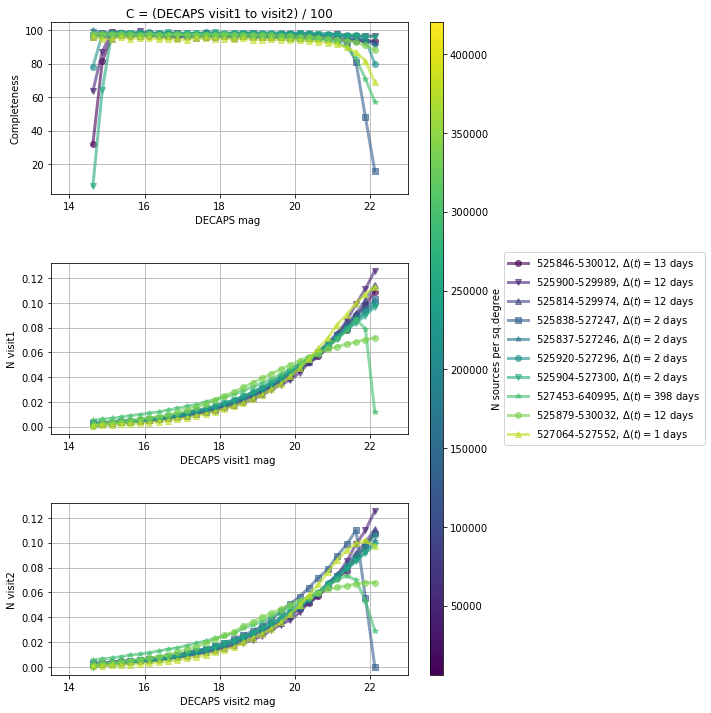

In [90]:
# Plotting : 
import matplotlib
import matplotlib.lines as mlines

bad_visits1 = [644144, 526028, 567795, 644082, 567283,
              644074, 611969,641548, 641497]
mask = ~np.in1d(stats['visit1'] , bad_visits1)
plot_visits1 = np.array(stats['visit1'])[mask]
i_choice = np.array(stats['i'])[mask]

N = len(plot_visits1)
colors = (np.arange(N+1)/N) 
cmap = matplotlib.cm.get_cmap('viridis') # ('cubehelix') #('jet')

# plot setup 
markers = ['o','v', '^','s','D','*']
#markers = [' ']

step = False
visit_legend = True 
fig,ax = plt.subplots(3,1,figsize=(8,12))
alpha = 0.6
lw= 3
#  2) iterating over visits, choose from the stats dictionary only those
#   values that correspond to wanted visits ... 

ax_legend_handles = []
source = 'decaps'
for j, pair in enumerate(np.array(pairs)[i_choice]) : 
    visit1,visit2 = pair[0], pair[1]
    print('Plotting ', visit1, ' to ', visit2, ' of ', source )
    mask = np.array(stats['visit1']) == visit1
    row_index = np.array(stats['i'])[mask][0]
    
    color = cmap(colors[j]) 
    density =  stats['density'][row_index]
    
    # go in the loop over markers
    marker = markers[stats['i'][row_index]%len(markers)] 
    
    bins = stats['bins'][row_index]
    bin_centers = (bins[:-1] + bins[1:])/2
    
    row  = np.array(chosen_visits['visit_1']) == visit1
    dmjd = int(abs(np.array(chosen_visits['dmjd'])[row][0]))
    
    # make a line for the legend, one line per visit 
    line = mlines.Line2D([], [], color=color, marker=marker, alpha=alpha,
                         label=str(visit1)+'-'+str(visit2)+', '+\
                         r'$\Delta(t)=$'+str(dmjd)+' days',lw=lw)
    ax_legend_handles.append(line)

    # plotting completeness
    title = 'C = (DECAPS visit1 to visit2) / 100'
    completeness = stats['decaps1-decaps2_completeness'][row_index]
    ax[0].plot(bin_centers, completeness,c=color, marker=marker, alpha=alpha,
              lw=lw)
    
    # plot counts
    for k in [1,2]:
        count = stats[source+str(k)+'_count'][row_index]
        ax[k].plot(bin_centers, count, c=color, marker=marker, alpha=alpha,
                    lw=lw)
        
    fig.subplots_adjust(hspace=0.4)
    
#  axis titles
ax[0].set_xlabel(source.upper()+' mag ')
ax[0].set_ylabel('Completeness')
ax[0].set_title(title)

ax[1].set_xlabel('DECAPS visit1 mag ')
ax[1].set_ylabel('N visit1')
    
ax[2].set_xlabel('DECAPS visit2 mag ')
ax[2].set_ylabel('N visit2')

# add a grid to all subplots ... 
for i in range(len(ax)):
    ax[i].set_xlim(13.5,23)
    ax[i].grid()

# add a big colorbar to the four panels   
densities = visit_table['mean_N_per_sq_deg']
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(densities), 
                           vmax=max(densities)))
sm._A = []
cax,kw = matplotlib.colorbar.make_axes([ax for ax in ax.flat],
                                      aspect=50)
plt.colorbar(sm, cax=cax,
             label='N sources per sq.degree') 

# add a legend with visits to the panels 
if visit_legend :
    plt.legend(bbox_to_anchor=(5.3,0.5),
             fancybox=True, loc="center left",
         handles = ax_legend_handles, ncol=1)

plt.savefig('completeness_3_decaps.png', bbox_inches='tight')
plt.show()

